# Stock NeurIPS2018 Part 3. Backtest
This series is a reproduction of paper *the process in the paper Practical Deep Reinforcement Learning Approach for Stock Trading*. 

This is the third and last part of the NeurIPS2018 series, introducing how to use use the agents we trained to do backtest, and compare with baselines such as Mean Variance Optimization and DJIA index.

Other demos can be found at the repo of [FinRL-Tutorials]((https://github.com/AI4Finance-Foundation/FinRL-Tutorials)).

# Part 1. Install Packages

In [1]:
## install finrl library
!pip install git+https://github.com/AI4Finance-Foundation/FinRL.git

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from stable_baselines3 import A2C, DDPG, PPO, SAC, TD3

# from customDRL import DRLAgent
from custommodels import DRLAgent
# from finrl.agents.stablebaselines3.models import DRLAgent


from finrl.config import INDICATORS, TRAINED_MODEL_DIR
# from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv
from customenv import StockTradingEnv
from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

%matplotlib inline

# Part 2. Backtesting

To backtest the agents, upload trade_data.csv in the same directory of this notebook. For Colab users, just upload trade_data.csv to the default directory.

In [2]:
train = pd.read_csv('train_data.csv')
trade = pd.read_csv('trade_data.csv')

# If you are not using the data generated from part 1 of this tutorial, make sure 
# it has the columns and index in the form that could be make into the environment. 
# Then you can comment and skip the following lines.
train = train.set_index(train.columns[0])
train.index.names = ['']
trade = trade.set_index(trade.columns[0])
trade.index.names = ['']

Then, upload the trained agent to the same directory, and set the corresponding variable to True.

In [25]:
if_using_a2c = True
if_using_ddpg = True
if_using_ddpg_good = False
if_using_ppo = True
if_using_td3 = True
if_using_sac = False

Load the agents

In [28]:
trained_a2c = A2C.load(TRAINED_MODEL_DIR + "/agent_a2c") if if_using_a2c else None
trained_ddpg = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg") if if_using_ddpg else None
trained_ddpg_good = DDPG.load(TRAINED_MODEL_DIR + "/agent_ddpg_good") if if_using_ddpg_good else None
trained_ppo = PPO.load(TRAINED_MODEL_DIR + "/agent_ppo_goat") if if_using_ppo else None
trained_td3 = TD3.load(TRAINED_MODEL_DIR + "/agent_td3") if if_using_td3 else None
trained_sac = SAC.load(TRAINED_MODEL_DIR + "/agent_sac") if if_using_sac else None

/opt/homebrew/lib/python3.10/site-packages/stable_baselines3/common/buffers.py:241: UserWarning: This system does not have apparently enough memory to store the complete replay buffer 36.05GB > 4.80GB
  warnings.warn(


### Trading (Out-of-sample Performance)

We update periodically in order to take full advantage of the data, e.g., retrain quarterly, monthly or weekly. We also tune the parameters along the way, in this notebook we use the in-sample data from 2009-01 to 2020-07 to tune the parameters once, so there is some alpha decay here as the length of trade date extends. 

Numerous hyperparameters – e.g. the learning rate, the total number of samples to train on – influence the learning process and are usually determined by testing some variations.

In [5]:
stock_dimension = len(trade.tic.unique())
state_space = 1 + 2 * stock_dimension + len(INDICATORS) * stock_dimension
print(f"Stock Dimension: {stock_dimension}, State Space: {state_space}")

Stock Dimension: 429, State Space: 4291


In [6]:
buy_cost_list = sell_cost_list = [0.001] * stock_dimension
num_stock_shares = [0] * stock_dimension

env_kwargs = {
    "hmax": 100,
    "initial_amount": 10000,
    "num_stock_shares": num_stock_shares,
    "buy_cost_pct": buy_cost_list,
    "sell_cost_pct": sell_cost_list,
    "state_space": state_space,
    "stock_dim": stock_dimension,
    "tech_indicator_list": INDICATORS,
    "action_space": stock_dimension,
    "reward_scaling": 1e-3,
}

In [7]:
e_trade_gym = StockTradingEnv(df = trade, turbulence_threshold = 70,risk_indicator_col='vix', **env_kwargs)
# env_trade, obs_trade = e_trade_gym.get_sb_env()

In [9]:
df_account_value_a2c, df_actions_a2c = DRLAgent.DRL_prediction(
    model=trained_a2c, 
    environment = e_trade_gym) if if_using_a2c else (None, None)

df_actions_filled = df_actions_a2c.fillna(0)

# Filter to keep only rows with at least one non-zero value
non_zero_rows = df_actions_filled.loc[(df_actions_filled != 0).any(axis=1)]

# For each row in the filtered DataFrame, keep only columns with non-zero values
non_zero_actions_only = non_zero_rows.apply(lambda row: row[row != 0], axis=1)

# # Print the resulting DataFrame
print(non_zero_actions_only)

hit end lsdjflskdjflks!
            IVZ  NKE  NUE  RHI
date                          
2022-07-01    2   43   35   29


In [10]:
df_account_value_ddpg, df_actions_ddpg = DRLAgent.DRL_prediction(
    model=trained_ddpg, 
    environment = e_trade_gym) if if_using_ddpg else (None, None)

df_actions_filled = df_actions_ddpg.fillna(0)
# Filter to keep only rows with at least one non-zero value
non_zero_rows = df_actions_filled.loc[(df_actions_filled != 0).any(axis=1)]

# For each row in the filtered DataFrame, keep only columns with non-zero values
non_zero_actions_only = non_zero_rows.apply(lambda row: row[row != 0], axis=1)

# Print the resulting DataFrame
print(non_zero_actions_only)


# print actions between 11-01-2022 and 02-06-2023
# # index by date
# for i in range(len(df_actions_ddpg)):
#     print(df_actions_ddpg.iloc[i])
print(df_account_value_ddpg)
# plot actions between 11-01-2022 and 02-06-2023
# plt.figure(figsize=(15, 5))
# plt.subplot(1, 2, 1)
# plt.title('DDPG')
# plt.plot(df_account_value_ddpg["account_value"])
# plt.subplot(1, 2, 2)
# plt.title('DDPG Actions')
# plt.plot(df_actions_ddpg.index, df_actions_ddpg['actions'], marker='o', markersize=2, linestyle='')
# plt.show()

hit end lsdjflskdjflks!
            F   J
date             
2022-07-01  2  80
           date  account_value
0    2022-07-01   10000.000000
1    2022-07-05    9809.203394
2    2022-07-06    9902.812332
3    2022-07-07   10027.649586
4    2022-07-08    9966.081667
..          ...            ...
349  2023-11-20   10958.389992
350  2023-11-21   10008.008152
351  2023-11-22    9918.723698
352  2023-11-24    9871.891237
353  2023-11-27    9795.128883

[354 rows x 2 columns]


In [ ]:
from stable_baselines3.common.evaluation import evaluate_policy

mean_reward, std_reward = evaluate_policy(trained_a2c, e_trade_gym, n_eval_episodes=30)
print(f"Mean reward: {mean_reward}, Std reward: {std_reward}")

/opt/homebrew/lib/python3.10/site-packages/stable_baselines3/common/evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


day: 353, episode: 20
begin_total_asset: 10000.00
end_total_asset: 12595.44
total_reward: 2595.44
total_cost: 9.99
total_trades: 72365
Sharpe: 0.737
day: 353, episode: 30
begin_total_asset: 10000.00
end_total_asset: 12595.44
total_reward: 2595.44
total_cost: 9.99
total_trades: 72365
Sharpe: 0.737


KeyboardInterrupt: 

In [11]:
df_account_value_ppo, df_actions_ppo = DRLAgent.DRL_prediction(
    model=trained_ppo, 
    environment = e_trade_gym) if if_using_ppo else (None, None)
df_actions_filled = df_actions_ppo.fillna(0)

# Filter to keep only rows with at least one non-zero value
non_zero_rows = df_actions_filled.loc[(df_actions_filled != 0).any(axis=1)]

# For each row in the filtered DataFrame, keep only columns with non-zero values
non_zero_actions_only = non_zero_rows.apply(lambda row: row[row != 0], axis=1)

# Print the resulting DataFrame
print(non_zero_actions_only)

day: 353, episode: 10
begin_total_asset: 10000.00
end_total_asset: 20011.78
total_reward: 10011.78
total_cost: 9.98
total_trades: 73432
Sharpe: 1.876
hit end lsdjflskdjflks!
            AAL  BR  DHI  MDLZ  NVDA  RJF
date                                     
2022-07-01    3  22   22    22    22    9


In [29]:
df_account_value_td3, df_actions_td3 = DRLAgent.DRL_prediction(
    model=trained_td3, 
    environment = e_trade_gym) if if_using_td3 else (None, None)

# print actions_td3 to see the actions taken by the agent, but only where not zero
df_actions_filled = df_actions_td3.fillna(0)

# Filter to keep only rows with at least one non-zero value
non_zero_rows = df_actions_filled.loc[(df_actions_filled != 0).any(axis=1)]

# For each row in the filtered DataFrame, keep only columns with non-zero values
non_zero_actions_only = non_zero_rows.apply(lambda row: row[row != 0], axis=1)

# Print the resulting DataFrame
print(non_zero_actions_only)

# print the date july 3rd 2020



hit end lsdjflskdjflks!
            FCX  HBAN  ZBRA
date                       
2022-07-01    3     2    33


In [ ]:
df_account_value_sac, df_actions_sac = DRLAgent.DRL_prediction(
    model=trained_sac, 
    environment = e_trade_gym) if if_using_sac else (None, None)

df_actions_filled = df_actions_sac

# Filter to keep only rows with at least one non-zero value
non_zero_rows = df_actions_filled.loc[(df_actions_filled != 0).any(axis=1)]

# For each row in the filtered DataFrame, keep only columns with non-zero values
non_zero_actions_only = non_zero_rows.apply(lambda row: row[row != 0], axis=1)

# Print the resulting DataFrame
print(non_zero_actions_only)

AttributeError: 'NoneType' object has no attribute 'loc'

In [ ]:
df_account_value_ddpg_good, df_actions_ddpg_good = (
    DRLAgent.DRL_prediction(model=trained_ddpg_good, environment=e_trade_gym)
    if if_using_ddpg_good
    else (None, None)
)

# Part 3: Mean Variance Optimization

Mean Variance optimization is a very classic strategy in portfolio management. Here, we go through the whole process to do the mean variance optimization and add it as a baseline to compare.

First, process dataframe to the form for MVO weight calculation.

In [30]:
def process_df_for_mvo(df):
  return df.pivot(index="date", columns="tic", values="close")

### Helper functions for mean returns and variance-covariance matrix

In [31]:
# Codes in this section partially refer to Dr G A Vijayalakshmi Pai

# https://www.kaggle.com/code/vijipai/lesson-5-mean-variance-optimization-of-portfolios/notebook

def StockReturnsComputing(StockPrice, Rows, Columns): 
  import numpy as np 
  StockReturn = np.zeros([Rows-1, Columns]) 
  for j in range(Columns):        # j: Assets 
    for i in range(Rows-1):     # i: Daily Prices 
      StockReturn[i,j]=((StockPrice[i+1, j]-StockPrice[i,j])/StockPrice[i,j])* 100 
      
  return StockReturn

### Calculate the weights for mean-variance

In [32]:
StockData = process_df_for_mvo(train)
TradeData = process_df_for_mvo(trade)

TradeData.to_numpy()

array([[117.778,  13.13 , 137.562, ..., 112.91 , 105.806, 299.34 ],
       [119.112,  13.88 , 140.166, ..., 113.51 , 105.432, 302.33 ],
       [119.725,  13.89 , 141.513, ..., 113.027, 104.287, 294.53 ],
       ...,
       [123.58 ,  12.31 , 191.066, ..., 127.694, 113.39 , 225.86 ],
       [126.201,  12.31 , 189.728, ..., 127.268, 112.992, 228.92 ],
       [124.597,  12.18 , 189.548, ..., 127.054, 113.4  , 231.5  ]])

In [33]:
#compute asset returns
arStockPrices = np.asarray(StockData)
[Rows, Cols]=arStockPrices.shape
arReturns = StockReturnsComputing(arStockPrices, Rows, Cols)

#compute mean returns and variance covariance matrix of returns
meanReturns = np.mean(arReturns, axis = 0)
covReturns = np.cov(arReturns, rowvar=False)
 
#set precision for printing results
np.set_printoptions(precision=3, suppress = True)

#display mean returns and variance-covariance matrix of returns
print('Mean returns of assets in k-portfolio 1\n', meanReturns)
print('Variance-Covariance matrix of returns\n', covReturns)

Mean returns of assets in k-portfolio 1
 [0.089 0.082 0.131 0.061 0.064 0.082 0.102 0.087 0.053 0.072 0.09  0.054
 0.054 0.058 0.064 0.083 0.077 0.077 0.081 0.1   0.139 0.064 0.097 0.169
 0.077 0.062 0.105 0.081 0.131 0.079 0.068 0.093 0.036 0.069 0.086 0.057
 0.066 0.066 0.073 0.077 0.135 0.089 0.092 0.067 0.072 0.07  0.04  0.096
 0.068 0.053 0.036 0.044 0.071 0.07  0.041 0.116 0.045 0.194 0.072 0.059
 0.087 0.066 0.065 0.062 0.129 0.048 0.038 0.052 0.047 0.07  0.06  0.126
 0.087 0.022 0.129 0.098 0.103 0.07  0.039 0.102 0.071 0.041 0.047 0.079
 0.064 0.078 0.114 0.088 0.076 0.112 0.054 0.078 0.099 0.06  0.08  0.082
 0.035 0.095 0.079 0.081 0.115 0.052 0.105 0.086 0.101 0.077 0.078 0.054
 0.05  0.047 0.071 0.064 0.085 0.106 0.107 0.045 0.102 0.084 0.059 0.076
 0.09  0.045 0.073 0.154 0.079 0.066 0.05  0.049 0.046 0.186 0.081 0.077
 0.058 0.05  0.074 0.059 0.044 0.102 0.094 0.081 0.049 0.071 0.098 0.066
 0.059 0.058 0.066 0.075 0.035 0.059 0.109 0.03  0.049 0.101 0.115 0.083
 0.076 0.0

### Use PyPortfolioOpt

In [34]:
from pypfopt.efficient_frontier import EfficientFrontier

ef_mean = EfficientFrontier(meanReturns, covReturns, weight_bounds=(0, 0.5))
raw_weights_mean = ef_mean.max_sharpe()
cleaned_weights_mean = ef_mean.clean_weights()
mvo_weights = np.array(
    [10000 * cleaned_weights_mean[i] for i in range(len(cleaned_weights_mean))]
)
mvo_weights

/opt/homebrew/lib/python3.10/site-packages/cvxpy/problems/problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


array([   0. ,    0. , 1199.5,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,  134. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,  409.7,
          0. ,    0. ,  570.5,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
        340.2,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
          0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,    0. ,
      

In [35]:
LastPrice = np.array([1/p for p in StockData.tail(1).to_numpy()[0]])
Initial_Portfolio = np.multiply(mvo_weights, LastPrice)
Initial_Portfolio

array([ 0.   ,  0.   ,  8.861,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  1.262,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  2.85 ,
        0.   ,  0.   ,  0.265,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        5.336,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
      

In [36]:
Portfolio_Assets = TradeData @ Initial_Portfolio
MVO_result = pd.DataFrame(Portfolio_Assets, columns=["Mean Var"])
MVO_result

,Mean Var
date,
2022-07-01,10222.866730
2022-07-05,10224.437485
2022-07-06,10260.649426
2022-07-07,10417.374878
2022-07-08,10392.260425
...,...
2023-11-20,12737.658774
2023-11-21,12751.615074
2023-11-22,12813.272291


# Part 4: DJIA index

Add DJIA index as a baseline to compare with.

In [37]:
TRAIN_START_DATE = "2009-01-01"
TRAIN_END_DATE = "2022-07-01"
TRADE_START_DATE = "2022-07-01"
TRADE_END_DATE = "2023-11-29"

In [38]:
df_apple = YahooDownloader(
    start_date=TRADE_START_DATE, end_date=TRADE_END_DATE, ticker_list=["AAPL"]
).fetch_data()

df_crox = YahooDownloader(
    start_date=TRADE_START_DATE, end_date=TRADE_END_DATE, ticker_list=["CROX"]
).fetch_data()

df_lly = YahooDownloader(
    start_date=TRADE_START_DATE, end_date=TRADE_END_DATE, ticker_list=["LLY"]
).fetch_data()

df_de = YahooDownloader(
    start_date=TRADE_START_DATE, end_date=TRADE_END_DATE, ticker_list=["DE"]
).fetch_data()

df_sp500 = YahooDownloader(
    start_date=TRADE_START_DATE, end_date=TRADE_END_DATE, ticker_list=["^GSPC"]
).fetch_data()



[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (355, 8)
[*********************100%%**********************]  1 of 1 completed

/opt/homebrew/lib/python3.10/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/homebrew/lib/python3.10/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



Shape of DataFrame:  (355, 8)
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (355, 8)
[*********************100%%**********************]  1 of 1 completed

/opt/homebrew/lib/python3.10/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')
/opt/homebrew/lib/python3.10/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')



Shape of DataFrame:  (355, 8)
[*********************100%%**********************]  1 of 1 completed
Shape of DataFrame:  (355, 8)


/opt/homebrew/lib/python3.10/site-packages/yfinance/utils.py:771: FutureWarning: The 'unit' keyword in TimedeltaIndex construction is deprecated and will be removed in a future version. Use pd.to_timedelta instead.
  df.index += _pd.TimedeltaIndex(dst_error_hours, 'h')


In [39]:
df_apple = df_apple[["date", "close"]]
fst_day = df_apple["close"][0]
apple = pd.merge(
    df_apple["date"],
   df_apple["close"].div(fst_day).mul(10000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

df_crox = df_crox[["date", "close"]]
fst_day = df_crox["close"][0]
crox = pd.merge(
    df_crox["date"],
    df_crox["close"].div(fst_day).mul(10000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

df_lly = df_lly[["date", "close"]]
fst_day = df_lly["close"][0]
lly = pd.merge(
    df_lly["date"],
    df_lly["close"].div(fst_day).mul(10000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

df_de = df_de[["date", "close"]]
fst_day = df_de["close"][0]
de = pd.merge(
    df_de["date"],
    df_de["close"].div(fst_day).mul(10000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

df_sp500 = df_sp500[["date", "close"]]
fst_day = df_sp500["close"][0]
sp500 = pd.merge(
    df_sp500["date"],
    df_sp500["close"].div(fst_day).mul(10000),
    how="outer",
    left_index=True,
    right_index=True,
).set_index("date")

<a id='4'></a>
# Part 5: Backtesting Results
Backtesting plays a key role in evaluating the performance of a trading strategy. Automated backtesting tool is preferred because it reduces the human error. We usually use the Quantopian pyfolio package to backtest our trading strategies. It is easy to use and consists of various individual plots that provide a comprehensive image of the performance of a trading strategy.

In [40]:
df_result_a2c = (
    df_account_value_a2c.set_index(df_account_value_a2c.columns[0])
    if if_using_a2c
    else None
)
df_result_ddpg = (
    df_account_value_ddpg.set_index(df_account_value_ddpg.columns[0])
    if if_using_ddpg
    else None
)
df_result_ppo = (
    df_account_value_ppo.set_index(df_account_value_ppo.columns[0])
    if if_using_ppo
    else None
)
df_result_td3 = (
    df_account_value_td3.set_index(df_account_value_td3.columns[0])
    if if_using_td3
    else None
)
df_result_sac = (
    df_account_value_sac.set_index(df_account_value_sac.columns[0])
    if if_using_sac
    else None
)

df_result_ddpg_good = (
    df_account_value_ddpg_good.set_index(df_account_value_ddpg_good.columns[0])
    if if_using_ddpg_good
    else None
)

result = pd.DataFrame(
    {
        "a2c": df_result_a2c["account_value"] if if_using_a2c else None,
        "ddpg": df_result_ddpg["account_value"] if if_using_ddpg else None,
        "ppo": df_result_ppo["account_value"] if if_using_ppo else None,
        "td3": df_result_td3["account_value"] if if_using_td3 else None,
        "sac": df_result_sac["account_value"] if if_using_sac else None,
        "ddpg_good": df_result_ddpg_good["account_value"] if if_using_ddpg_good else None,
        "mvo": MVO_result["Mean Var"],
        # "AAPL": apple["close"],
        # "CROX": crox["close"],
        # "LLY": lly["close"],
        # "DE": de["close"],
        "SP500": sp500["close"],
    }
)

In [41]:
result

,a2c,ddpg,ppo,td3,sac,ddpg_good,mvo,SP500
date,,,,,,,,
2022-07-01,10000.000000,10000.000000,10000.000000,10000.000000,None,None,10222.866730,10000.000000
2022-07-05,10137.574694,9809.203394,10131.290061,10083.103868,None,None,10224.437485,10015.841285
2022-07-06,10195.568836,9902.812332,10202.139833,9826.052858,None,None,10260.649426,10051.629532
2022-07-07,10570.122316,10027.649586,10401.561993,10181.985905,None,None,10417.374878,10202.048026
2022-07-08,10475.262919,9966.081667,10408.411395,9992.779777,None,None,10392.260425,10193.577556
...,...,...,...,...,...,...,...,...
2023-11-21,12406.556976,10008.008152,20324.529815,7475.917093,None,None,12751.615074,11863.525104
2023-11-22,12463.210133,9918.723698,20109.435584,7589.380564,None,None,12813.272291,11911.704413
2023-11-24,12435.045252,9871.891237,19918.259070,7690.231010,None,None,12868.357210,11918.814195


Now, everything is ready, we can plot the backtest result.

<Figure size 1500x500 with 0 Axes>

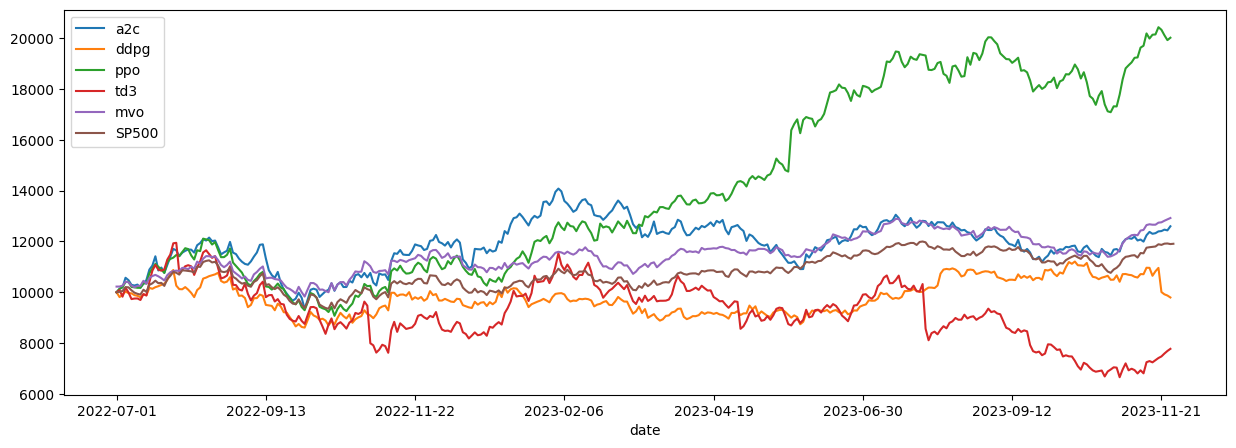

In [42]:
plt.rcParams["figure.figsize"] = (15,5)
plt.figure()
result.plot()
plt.savefig("result.png")